In [1]:
from bs4 import BeautifulSoup
import requests
import json
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

<Figure size 640x480 with 0 Axes>

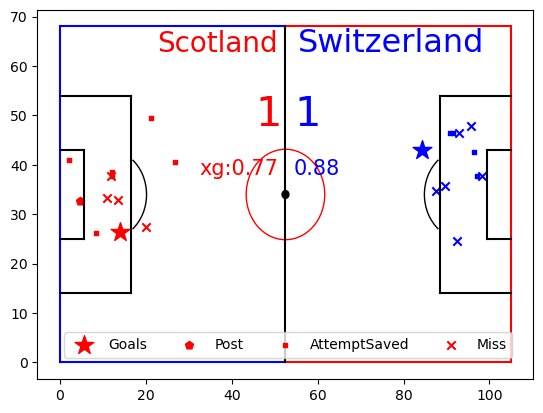

<Figure size 640x480 with 0 Axes>

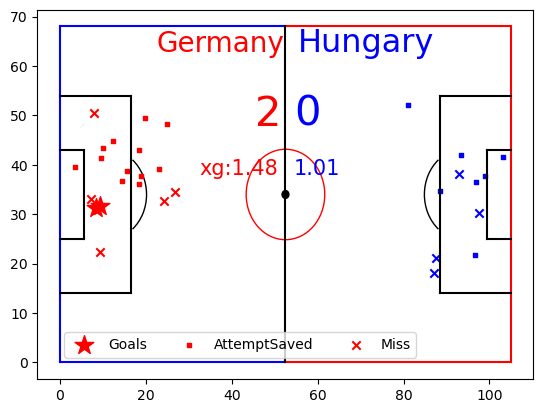

<Figure size 640x480 with 0 Axes>

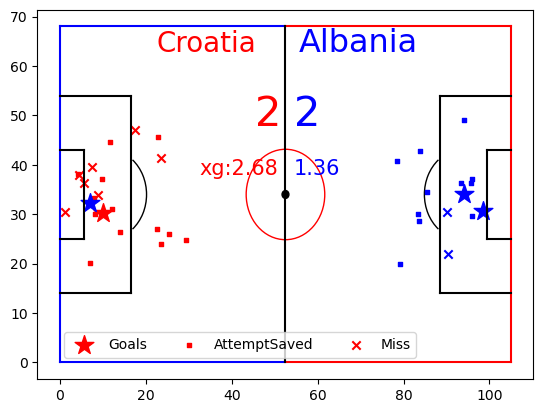

In [6]:
main()

In [5]:
def main():
    ID_list = ['4043837','4043838','4043843','4043844','4043855','4043850','4043849','4043862','4043861','4043856','4043867','4043868','4043839','4043840','4043845']
    for ID in ID_list:
        df_mrg = get_shots(ID)[0]
        df_names = get_shots(ID)[1]
        draw_figure(df_mrg,df_names)

In [2]:
def pitch_custom_fcpython_wait(x,y):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    
    plt.plot([0,0],[0,y], color="blue")
    plt.plot([0,x/2],[y,y], color="blue")
    plt.plot([x/2,x],[y,y], color="red")
    plt.plot([x,x],[y,0], color="red")
    plt.plot([x,x/2],[0,0], color="red")
    plt.plot([x/2,0],[0,0], color="blue")
    plt.plot([x/2,x/2],[0,y], color="black")

    #Assign circles to variables - do not fill the centre circle!
    centreCircle = plt.Circle((x/2,y/2),9.15,color="red",fill=False)
    centreSpot = plt.Circle((x/2,y/2),0.8,color="black")

    #Draw the circles to our plot
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)

    #Left Penalty Area
    plt.plot([16.5,16.5],[y/2-20,y/2+20],color="black")
    plt.plot([0,16.5],[y/2+20,y/2+20],color="black")
    plt.plot([16.5,0],[y/2-20,y/2-20],color="black")

    #Right Penalty Area
    plt.plot([x,x-16.5],[y/2+20,y/2+20],color="black")
    plt.plot([x-16.5,x-16.5],[y/2+20,y/2-20],color="black")
    plt.plot([x-16.5,x],[y/2-20,y/2-20],color="black")

    #Left 6-yard Box
    plt.plot([0,5.5],[y/2+9,y/2+9],color="black")
    plt.plot([5.5,5.5],[y/2+9,y/2-9],color="black")
    plt.plot([5.5,0],[y/2-9,y/2-9],color="black")

    #Right 6-yard Box
    plt.plot([x,x-5.5],[y/2+9,y/2+9],color="black")
    plt.plot([x-5.5,x-5.5],[y/2+9,y/2-9],color="black")
    plt.plot([x-5.5,x],[y/2-9,y/2-9],color="black")

    #Prepare Arcs
    leftArc = Arc((11,y/2),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((x-11,y/2),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

In [3]:
def get_shots(matchId):
    params = {
        'matchId': matchId,
    }
    response = requests.get('https://www.fotmob.com/api/matchDetails', params=params)
    data = response.json()
    shotmap = data['content']['shotmap']['shots']
    df = pd.DataFrame(shotmap)
    df = df.filter(items = ['teamId','eventType','playerName','min','x','y'])

    league = []
    gameweek = []
    season = []
    team = []
    team_id = []
    xg = []
    score = []

    team.append(data['general']['homeTeam']['name'])
    team.append(data['general']['awayTeam']['name'])
    team_id.append(data['general']['homeTeam']['id'])
    team_id.append(data['general']['awayTeam']['id'])
    #this is a little bit not efficient - doubling everything
    league.append(data['general']['leagueName'])
    league.append(data['general']['leagueName'])
    gameweek.append(data['general']['leagueRoundName'])
    gameweek.append(data['general']['leagueRoundName'])
    season.append(data['general']['parentLeagueSeason'])
    season.append(data['general']['parentLeagueSeason'])
    score.append(data['header']['teams'][0]['score'])
    score.append(data['header']['teams'][1]['score'])
    xg = data['content']['stats']['Periods']['All']['stats'][0]['stats'][1]['stats']

    col_name = ['TeamName','teamId','goals','xg','league','gameweek','season']
    df_names = pd.DataFrame([team,team_id,score,xg,league,gameweek,season],index=col_name)
    df_names = df_names.T

    df['teamId'] = df['teamId'].astype(str)
    df_names['teamId'] = df_names['teamId'].astype(str)
    df_mrg = pd.merge(df, df_names, on="teamId", how="left")
            
    df_mrg['x'] =   df_mrg['x'].apply(lambda x: round(x, 1))
    df_mrg['y'] =   df_mrg['y'].apply(lambda x: round(x, 1)) 

    path1 =  r'C:/Users/jakub/Documents/kursy/python/python_mckay/shots_'+team[0]+'_vs_'+team[1]+'.xlsx' 
    with pd.ExcelWriter(path1) as writer:
        df_mrg.to_excel(writer, sheet_name="Shots")
    return df_mrg,df_names

In [4]:
def draw_figure(df_mrg,df_names):
    
    pitch_len = 105
    pitch_width = 68
    pd.options.mode.chained_assignment = None  # default='warn'
    for index in range(len(df_mrg.TeamName)):
        if df_mrg.TeamName[index] == df_names.TeamName[0]:
            df_mrg.x[index] = pitch_len - df_mrg.x[index]
            df_mrg.y[index] = pitch_width - df_mrg.y[index]
        
    fig=plt.figure()
    pitch_custom_fcpython_wait(pitch_len,pitch_width)
    
    for index in range(len(df_mrg.TeamName)):
        if df_mrg.TeamName[index] == df_names.TeamName[0]:
            if df_mrg.eventType[index] == 'Goal':
                goals_home = plt.scatter(df_mrg['x'][index],df_mrg['y'][index],color='red', marker = "*", s = 200)
            elif df_mrg.eventType[index] == 'AttemptSaved':
                saved_home = plt.scatter(df_mrg['x'][index],df_mrg['y'][index],color='red', marker = "s", s = 10)
            elif df_mrg.eventType[index] == 'Post':
                post_home = plt.scatter(df_mrg['x'][index],df_mrg['y'][index],color='red', marker = "p")
            elif df_mrg.eventType[index] == 'Miss':
                miss_home = plt.scatter(df_mrg['x'][index],df_mrg['y'][index],color='red', marker = "x")
        else:
            if df_mrg.eventType[index] == 'Goal': 
                goals_away = plt.scatter(df_mrg['x'][index],df_mrg['y'][index],color='blue', marker = "*", s = 200)
            elif df_mrg.eventType[index] == 'AttemptSaved':
                saved_away = plt.scatter(df_mrg['x'][index],df_mrg['y'][index],color='blue', marker = "s", s = 10)
            elif df_mrg.eventType[index] == 'Post':
                post_away = plt.scatter(df_mrg['x'][index],df_mrg['y'][index],color='blue', marker = "p")
            elif df_mrg.eventType[index] == 'Miss':
                miss_away = plt.scatter(df_mrg['x'][index],df_mrg['y'][index],color='blue', marker = "x")

    plt.text(pitch_len/2 - 30, pitch_width-5, df_names.TeamName[0], fontsize = 20, color='red')
    plt.text(pitch_len/2 + 3,  pitch_width-5, df_names.TeamName[1], fontsize = 23, color='blue')

    plt.text(pitch_len/2 - 7, pitch_width-20, df_names.goals[0], fontsize = 30, color='red')
    plt.text(pitch_len/2 + 2, pitch_width-20, df_names.goals[1], fontsize = 30, color='blue')

    xghome = 'xg:' + df_names.xg[0]
    plt.text(pitch_len/2 - 20, pitch_width-30, xghome, fontsize = 15, color='red')
    plt.text(pitch_len/2 + 2, pitch_width-30, df_names.xg[1], fontsize = 15, color='blue')

    #possibly some games will have "bar"
    try:
        goals_home
    except:
        try:
            goals_away
        except:
            try:
                post_home
            except:
                try:
                    post_away
                except:
                    plt.legend((saved_home,miss_home),["AttemptSaved","Miss"], ncol = 4 , loc='lower left', bbox_to_anchor=(0.04, 0.04))
                else:
                    plt.legend((post_away,saved_home,miss_home),["Post","AttemptSaved","Miss"], ncol = 4 , loc='lower left', bbox_to_anchor=(0.04, 0.04))
            else:
                plt.legend((post_home,saved_home,miss_home),["Post","AttemptSaved","Miss"], ncol = 4 , loc='lower left', bbox_to_anchor=(0.04, 0.04))
        else:
            try:
                post_home
            except:
                try:
                    post_away
                except:
                    plt.legend((goals_away,saved_home,miss_home),["Goals","AttemptSaved","Miss"], ncol = 4 , loc='lower left', bbox_to_anchor=(0.04, 0.04))
                else:
                    plt.legend((goals_away,post_away,saved_home,miss_home),["Goals","Post","AttemptSaved","Miss"], ncol = 4 , loc='lower left', bbox_to_anchor=(0.04, 0.04))
            else:
                plt.legend((goals_away,post_home,saved_home,miss_home),["Goals","Post","AttemptSaved","Miss"], ncol = 4 , loc='lower left', bbox_to_anchor=(0.04, 0.04))
    else:
        try:
            post_home
        except:
            try:
                post_away
            except:
                plt.legend((goals_home,saved_home,miss_home),["Goals","AttemptSaved","Miss"], ncol = 4 , loc='lower left', bbox_to_anchor=(0.04, 0.04))
            else:
                plt.legend((goals_home,post_away,saved_home,miss_home),["Goals","Post","AttemptSaved","Miss"], ncol = 4 , loc='lower left', bbox_to_anchor=(0.04, 0.04))
        else:
            plt.legend((goals_home,post_home,saved_home,miss_home),["Goals","Post","AttemptSaved","Miss"], ncol = 4 , loc='lower left', bbox_to_anchor=(0.04, 0.04))
    plt.savefig('C:/Users/jakub/Documents/kursy/python/python_mckay/shots_map_'+df_names.TeamName[0]+'_vs_'+df_names.TeamName[1]+'.png')